In [33]:
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import datetime
import numpy as np

(array([  195052.,  1568317.,  1854541.,  4715418.,  5666339.,  6618897.,
        17601301., 18044334., 26426818.,   584759.]),
 array([195.32087708, 207.57647705, 219.83209229, 232.08770752,
        244.3433075 , 256.59890747, 268.85452271, 281.11013794,
        293.36572266, 305.62133789, 317.87695312]),
 <BarContainer object of 10 artists>)

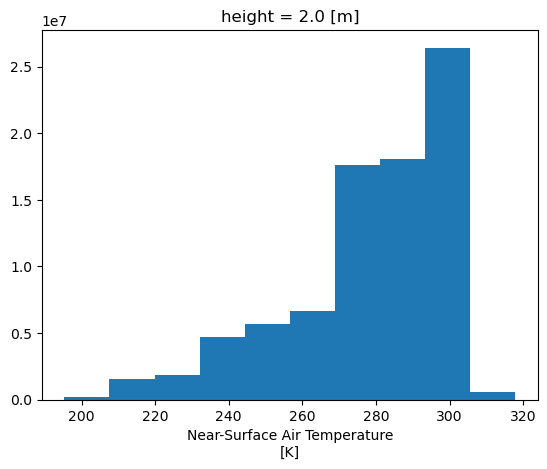

In [31]:
data = xr.open_dataset('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_000.nc')
data['tas'].plot()

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# fig = plt.figure(figsize=[12,5])

# 111 means 1 row, 1 col and index 1
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

# data['tas'].sel(time=slice("1850-01-16", "1900-01-16")).plot(cmap='jet', transform=ccrs.PlateCarree(), col='time')
# ax.coastlines()

# plt.show()

C:\Users\jqcla\AppData\Local\Temp\ipykernel_12900\3075423216.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


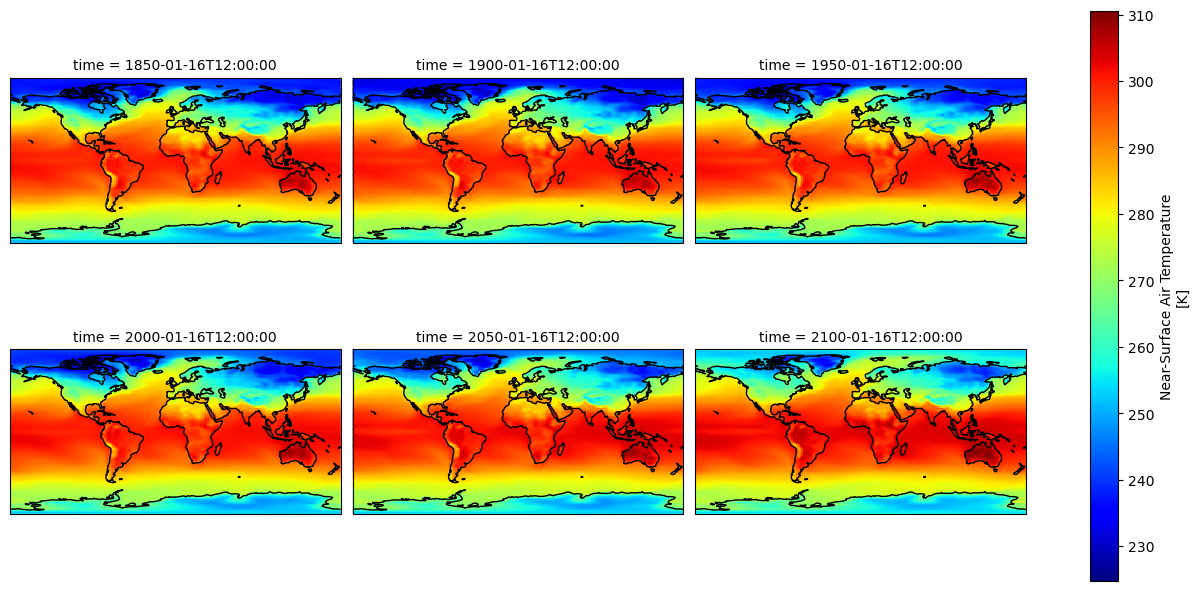

In [36]:
many_times = np.array([
    "1850-01-16",
    "1900-01-16",
    "1950-01-16",
    "2000-01-16",
    "2050-01-16",
    "2100-01-16",
], dtype=np.datetime64)

temp = data['tas'].sel(time=many_times, method='nearest')
map_proj = ccrs.PlateCarree(central_longitude=0)

p = temp.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=3,  # multiplot settings
             aspect=data.dims['lon'] / data.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj},
             cmap='jet')  # the plot's projection

for ax in p.axes.flat:
    ax.coastlines()
    # ax.set_extent([288, 336, -44, -12])
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    # ax.set_aspect('equal', 'box-forced')

plt.show()

In [38]:
data

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 192, time: 3012)
Coordinates:
    height   float64 ...
  * lat      (lat) float32 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
Data variables:
    tas      (time, lat, lon) float32 ...
Attributes: (12/53)
    CDI:                       Climate Data Interface version ?? (http://mpim...
    history:                   Thu Jun 24 08:56:03 2021: ncks -v tas tas_mon_...
    source:                    ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode...
    institution:               CSIRO (Commonwealth Scientific and Industrial ...
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    ...                        ...
    license:                   CMIP6 model data produced by CSIRO is licensed...
    cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
    original_file_names:       /net/atmos/data/cmip6/historical/Amon/tas/ACCE...
    original_file_hash_codes:  3e106e8430f04cd2b260a7230b1e461ccebdda338d09e3...
    CDO:                       Climate Data Operators version 1.9.3 (http://m...
    NCO:                       4.7.2

In [2]:
file = open("model_names.txt", "r") 
data = file.read() 
data_into_list = data.split("\n")
print(data_into_list) 
file.close() 

['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5 p1', 'CanESM5 p2', 'CanESM5-CanOE p2', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1 f2', 'CNRM-CM6-1-HR f2', 'CNRM-ESM2-1 f2', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G p1', 'GISS-E2-1-G p3', 'HadGEM3-GC31-LL f3', 'HadGEM3-GC31-MM f3', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'MCM-UA-1-0', 'MIROC6', 'MIROC-ES2L f2', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL f2']


In [9]:
data_l = []

def geog_agg(fn):
    ds = xr.open_dataset(f'{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

# for filename, model_name in zip(glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'), data_into_list):
#     # print(filename)
#     data = xr.open_dataset(filename)
#     data = data.rename({'tas': model_name})
#     data = data.convert_calendar("noleap", align_on='date')
#     data = data.resample(time='1M').first()
#     try:
#         data = data.drop_vars('height')
#     except ValueError:
#         print('column has no height var')
#     # try:
#     #     data.indexes['time'].to_datetimeindex()
#     # except AttributeError:
#     #     pass
#     data_l.append(data)

# big_df = xr.merge(data_l)

In [14]:
for filename in glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'):
    try:
        geog_agg(filename)
    except Exception as e: 
        print(f'{filename} failed {e}')

In [4]:
data_ds = xr.open_mfdataset(f'cmip6_agg*.nc', coords='minimal', compat='override')
data_ds.load()

<xarray.Dataset>
Dimensions:     (year: 251, model: 36, experiment: 1)
Coordinates:
    height      float64 2.0
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical'
Data variables:
    tas         (experiment, model, year) float32 13.7 13.71 ... 17.6 17.62

In [5]:
data = data_ds['tas']
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

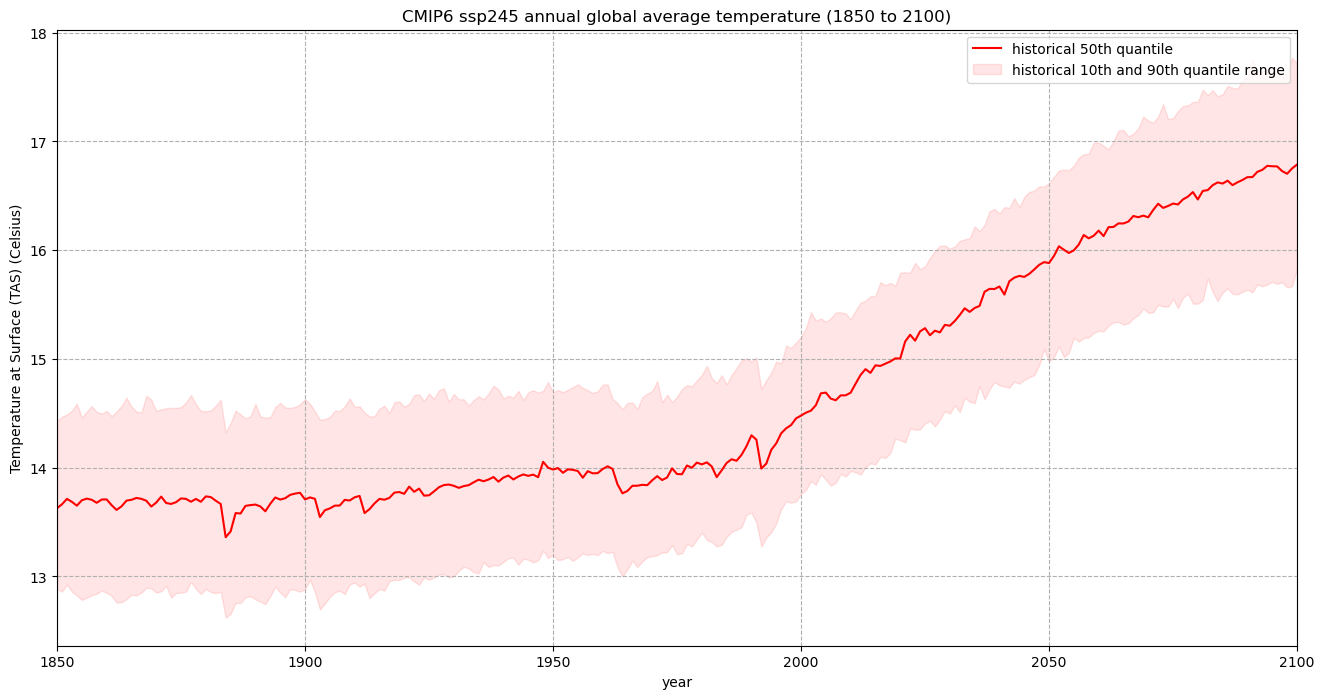

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['red']
experiments = ['ssp245']

for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

# fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

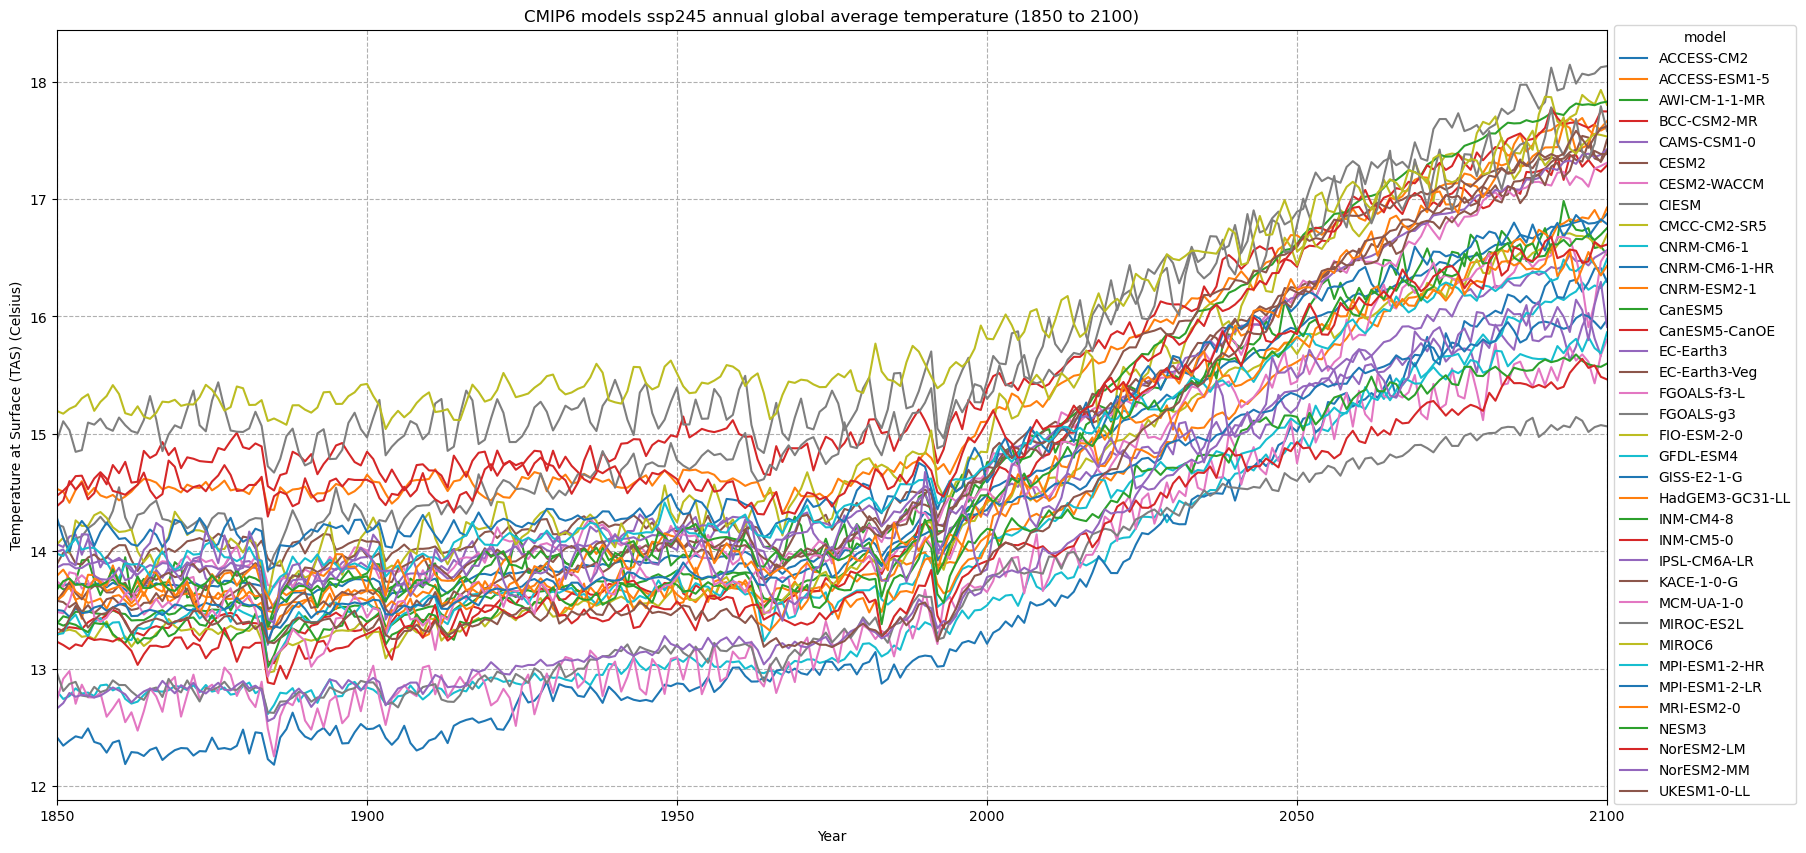

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
data.plot(x='year', hue='model', add_legend=True)
ax.set_xlim(1850,2100)
ax.set_title('CMIP6 models ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('Year')
sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='right', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper left')
ax.grid(linestyle='--')
plt.show()

In [38]:
data_ds.corr()

AttributeError: 'Dataset' object has no attribute 'corr'

In [47]:
tmp = data_ds.to_dataframe().reset_index()
tmp

,year,model,experiment,height,tas
0,1850,ACCESS-CM2,historical,2.0,13.703918
1,1850,ACCESS-ESM1-5,historical,2.0,14.530945
2,1850,AWI-CM-1-1-MR,historical,2.0,13.717590
3,1850,BCC-CSM2-MR,historical,2.0,14.384521
4,1850,CAMS-CSM1-0,historical,2.0,14.060303
...,...,...,...,...,...
9031,2100,MRI-ESM2-0,historical,2.0,16.431366
9032,2100,NESM3,historical,2.0,16.753021
9033,2100,NorESM2-LM,historical,2.0,16.612885
9034,2100,NorESM2-MM,historical,2.0,15.910614


In [50]:
corr = tmp.pivot(index='year', columns='model', values='tas').corr()

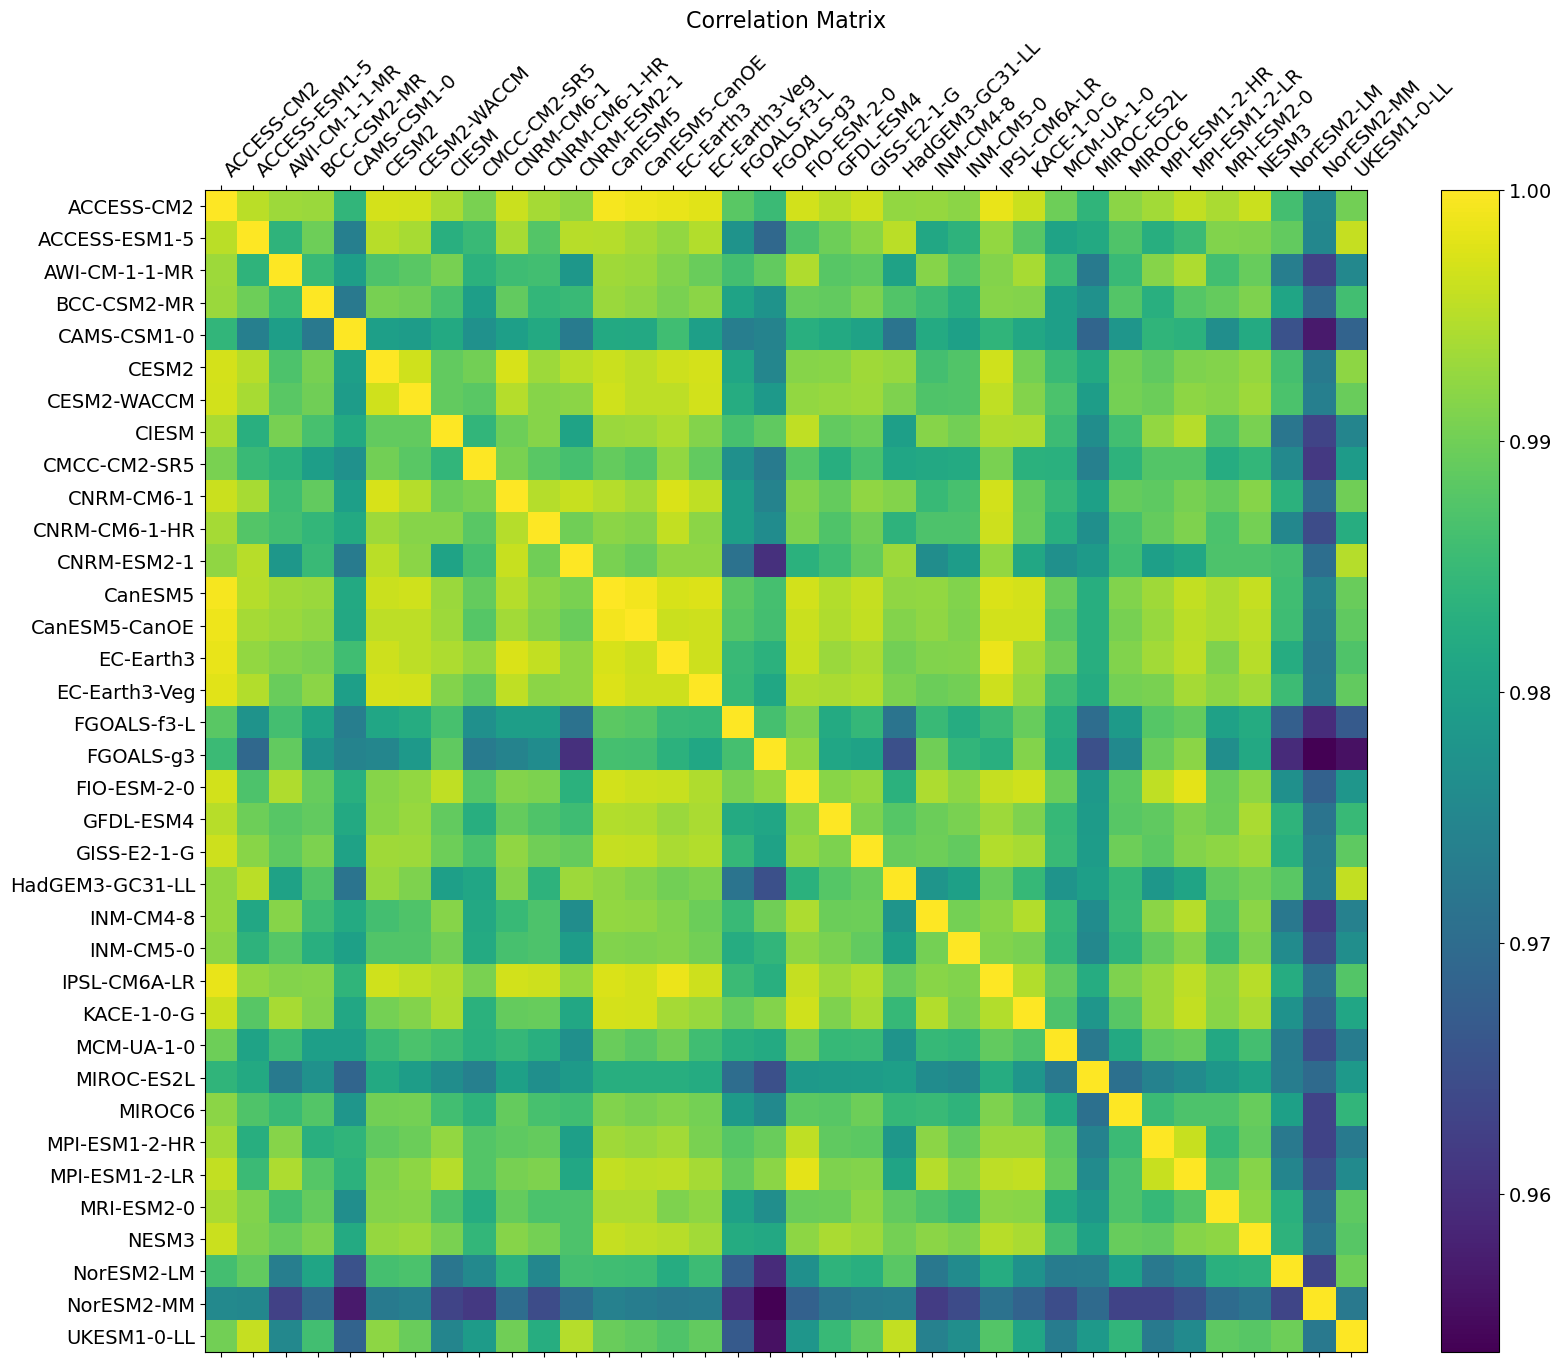

In [53]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Models Correlation Matrix', fontsize=16);